In [5]:
import pandas as pd
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from scipy.stats import trim_mean
from scipy.interpolate import interp1d
from invisible_cities.database  import load_db
import matplotlib.colors as mcolors
%matplotlib widget




In [6]:
def GetBaselineInterp(times, wfs):

    interps = []
    for wf in wfs:

        # Apply trimmed mean over a sliding window
        window_size = 20  # Adjust as needed
        trim_ratio = 0.4  # Trim 10% from each side

        trimmed_wfm = np.array([
            trim_mean(wf[i:i+window_size], proportiontocut=trim_ratio) 
            for i in range(0, len(wf), window_size)
        ])

        # Downsample the time array to match the trimmed values
        trimmed_times = times[::window_size]

        # Interpolate the smoothed data
        interp_func = interp1d(trimmed_times, trimmed_wfm, kind='cubic', bounds_error=False, fill_value=0)  # Cubic interpolation for smoothness
        interps.append(interp_func)

    return interps


def CorrectRawBaseline(wfs):

    corrected_waveforms = []

    for wfm in wfs:

        # Apply trimmed mean over a sliding window
        window_size = 20  # Adjust as needed
        trim_ratio = 0.4  # Trim 40% from each side

        trimmed_wfm = np.array([
            trim_mean(wfm[i:i+window_size], proportiontocut=trim_ratio) 
            for i in range(0, len(wfm), window_size)
        ])

        baseline = np.mean(trimmed_wfm[0:10])
        wfm = wfm-baseline
        corrected_waveforms.append(wfm)

    return np.array(corrected_waveforms)


def GetS2Areas(wfs, S2_start, S2_end):

    S2_areas = []

    for wf_sipm in wfs:
        S2_area = wf_sipm[int(S2_start):int(S2_end)]
        S2_area = S2_area[S2_area > 0].sum()
        S2_areas.append(S2_area)

    return S2_areas
    

def BaselineFit(interps, t_start, t_end):

    new_time = np.linspace(t_start,t_end,500)

    slopes = []
    intercepts = []
    offsets = []
    for interp in interps:
        interpolated_amplitude = interp(new_time)

        slope, intercept = np.polyfit(new_time, interpolated_amplitude, 1)
        offset = slope * t_start + intercept

        slopes.append(slope)
        intercepts.append(intercept)
        offsets.append(offset)

    return slopes,intercepts, offsets

# function to calculate the noise:
# get all hits below 30 ADC
# get rms in first 600 mus
def GetSiPMRMS(wfs):

    rms = []
    means = []

    for wf_sipm in wfs:

        wf_sipm_filtered = wf_sipm[wf_sipm < 30][:600]  # Filter values and take first 600
        rms_value = np.sqrt(np.mean(wf_sipm_filtered**2))  # Compute RMS
        rms.append(rms_value)
        means.append(np.mean(wf_sipm_filtered))

    return rms, means




In [7]:
RUN_NUMBER = 14498

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, RUN_NUMBER)
display(datasipm)

,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma
0,1000,56013,1,-482.625,-294.825,17.5356,2.26852
1,1001,56012,1,-482.625,-279.275,16.8348,1.89649
2,1002,56015,1,-482.625,-263.725,17.2957,2.26167
3,1003,56014,1,-482.625,-248.175,17.7361,2.26759
4,1004,56029,1,-482.625,-232.625,16.4249,2.19263
...,...,...,...,...,...,...,...
3579,56059,14054,1,490.025,245.425,17.3728,2.47312
3580,56060,14037,1,490.025,260.975,17.9931,1.99397
3581,56061,14036,1,490.025,276.525,16.5315,2.28669
3582,56062,14039,1,490.025,292.075,17.1426,2.05097


On Event: 33
S2 area is: 62213.04999999999
3584
Slope of the fitted line: 0.0168315785034625
Amplitude at time 1650: -22.970487495164075


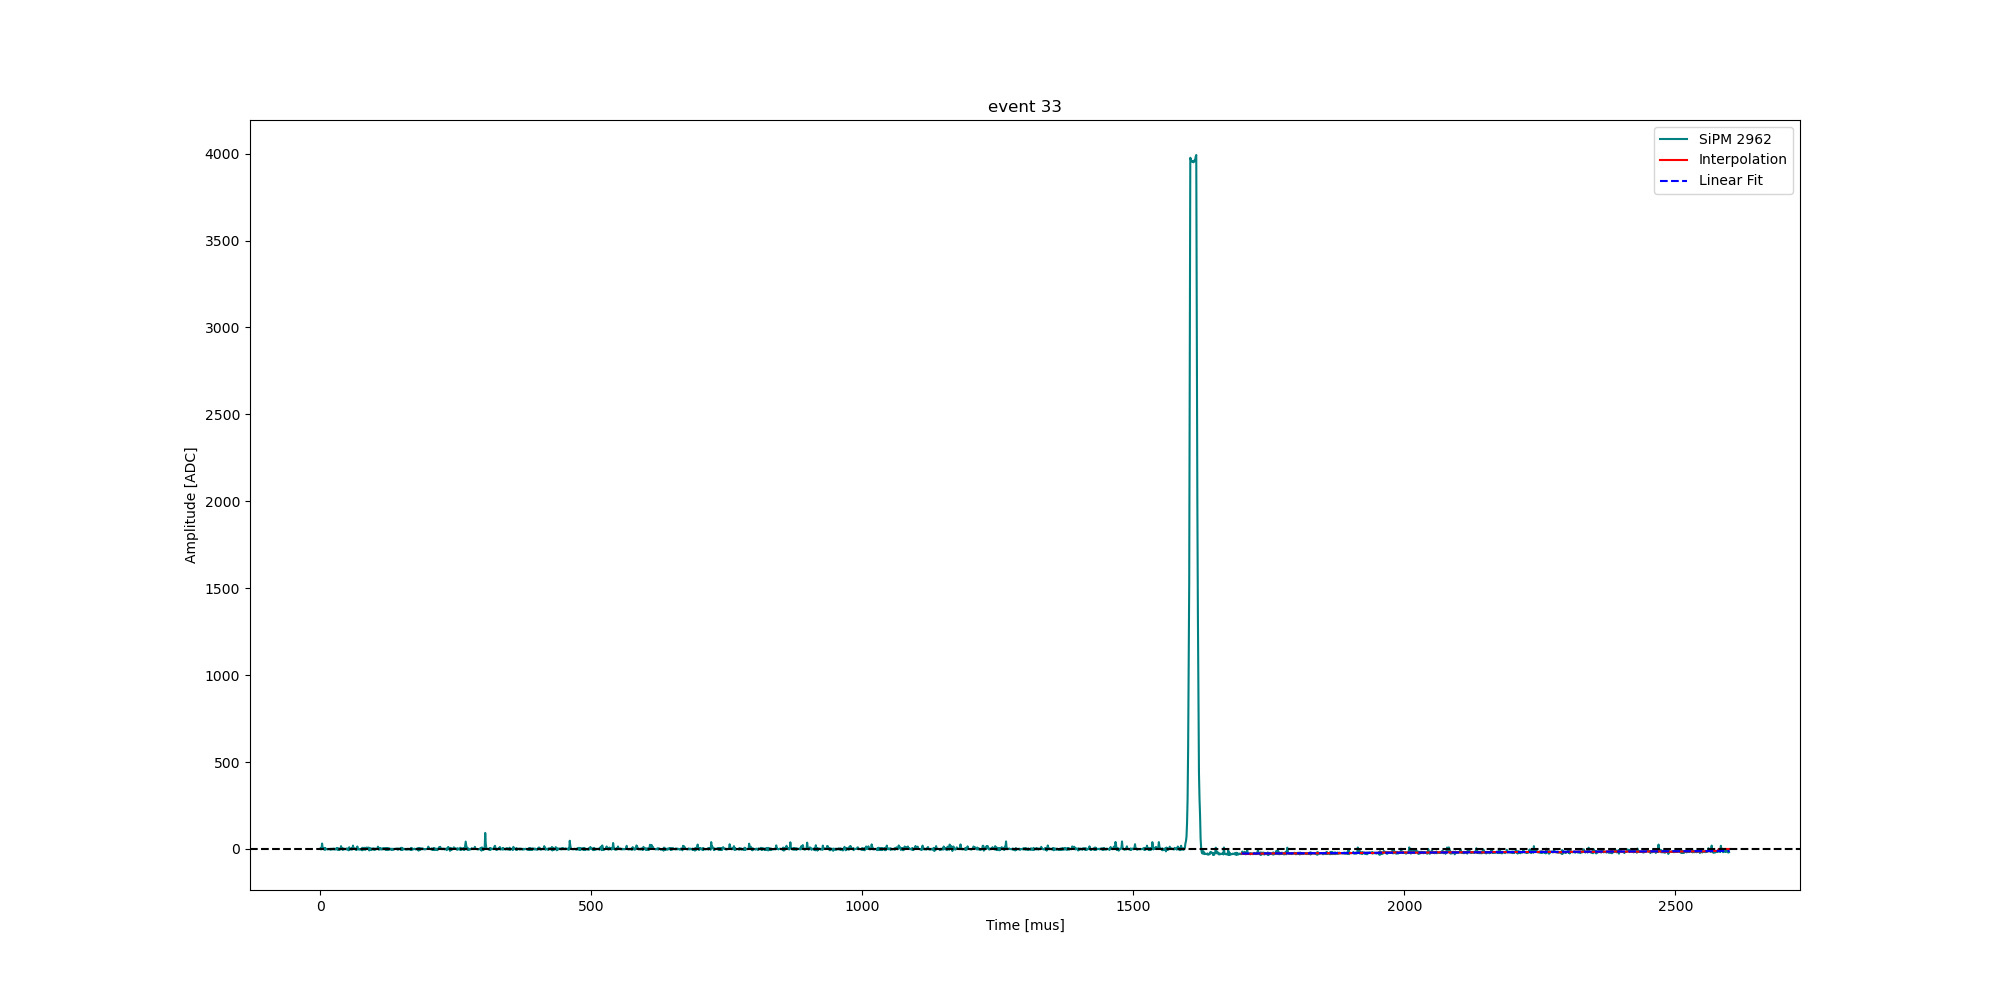

In [114]:



# plot_mode = "highest"
plot_mode = "2962"

# filename = "../data/run_14710_0000_ldc7_trg0.waveforms.h5"

# filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/run_14180_0049_ldc6_trg0.waveforms.h5" 
# filename = "../data/run_14583_0000_ldc1_trg0.waveforms.h5"
filename  = "../data/xenon/run_14498_0011_ldc3_trg0.waveforms.h5"
# filename = "../data/Kr/run_14893_0001_ldc1_trg0.waveforms.h5"

event_number = 33

# baselinewindow =  1700, 3000
# S2_start    = 1590
# S2_end      = 1640

# baselinewindow =  1100, 2000
# S2_start    = 990
# S2_end      = 1040

baselinewindow   = 1700, 2600
S2_start    = 1590
S2_end      = 1640


with tb.open_file(filename) as file:

    rwf      = file.root.RD.sipmrwf



    wfs = rwf[event_number]

    # # This corrects the baseline from ~50 to zero by shifting it
    wfs = CorrectRawBaseline(wfs)
    wfs = CorrectRawBaseline(wfs)
    # wfs = CorrectRawBaselineSecondary(wfs)

    print("On Event:", event_number)
    
    sp_sipm = 1     # sampling period in mus
    times  = np.arange(wfs[0].size) * sp_sipm

    # Choose which waveform to plot
    if (plot_mode == "highest"):
        index = np.argmax(np.max(wfs, axis=1))
        wf_sipm = wfs[index]
        plot_mode = index
    elif (plot_mode == "summed"):
        wf_sipm =  sum_wf(wfs)
    else:
        wf_sipm = wfs[int(plot_mode)]

    S2_areas = GetS2Areas(wfs,S2_start, S2_end)
    print("S2 area is:", S2_areas[int(plot_mode)])

    interps = GetBaselineInterp(times, wfs)
    print(len(interps))
    new_time = np.linspace(baselinewindow[0],baselinewindow[1],500)
    # new_time = np.linspace(900,1400,500)
    interpolated_amplitude = interps[int(plot_mode)](new_time)

    rms, means = GetSiPMRMS(wfs)

    slopes, intercepts, offsets = BaselineFit(interps, baselinewindow[0],baselinewindow[1])
    
    # If any values give a negative slope, then increase the baselinefit
    if any(x < 0 for x in slopes):
        slopes, intercepts, offsets = BaselineFit(interps, baselinewindow[0]+200,baselinewindow[1])

    # Print results
    print(f"Slope of the fitted line: {slopes[int(plot_mode)]}")
    print(f"Amplitude at time 1650: {offsets[int(plot_mode)]}")


    plt.figure(figsize=(20, 10))
    plt.plot(times, wf_sipm , label = f"SiPM {plot_mode}",  color = "Teal");
    plt.plot(new_time, interpolated_amplitude, label="Interpolation", color="red")
    plt.plot(new_time, slopes[int(plot_mode)] * new_time + intercepts[int(plot_mode)], label="Linear Fit", linestyle="--", color="blue")
    plt.ylabel("Amplitude [ADC]")
    plt.xlabel("Time [mus]")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.legend(loc = "upper right")
    plt.title(f"event {event_number}")
    # plt.xlim(1400, 2600)
    # plt.ylim(-10,60)

Text(0.5, 0, 'SiPM Index')

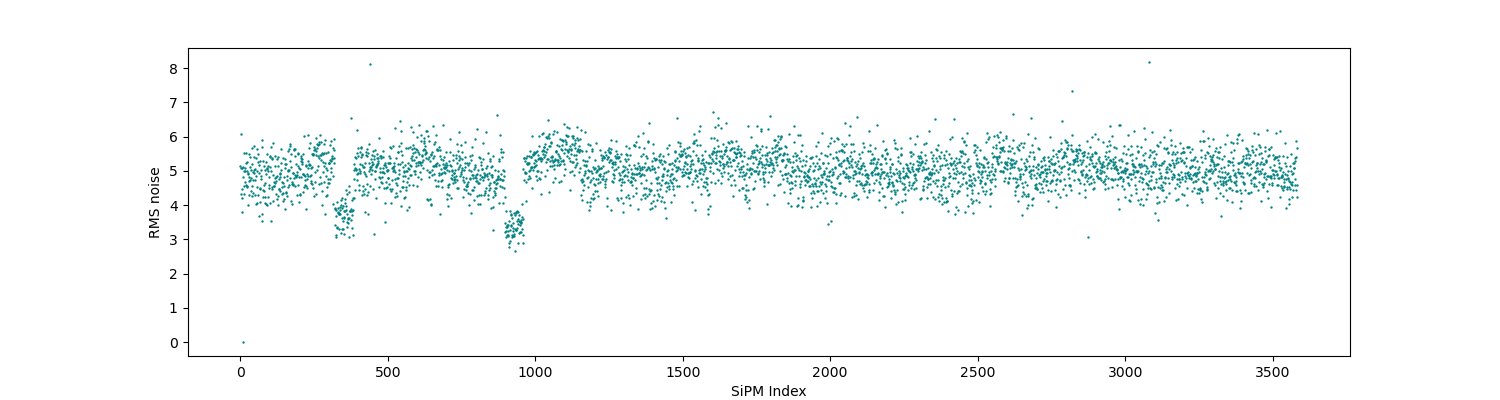

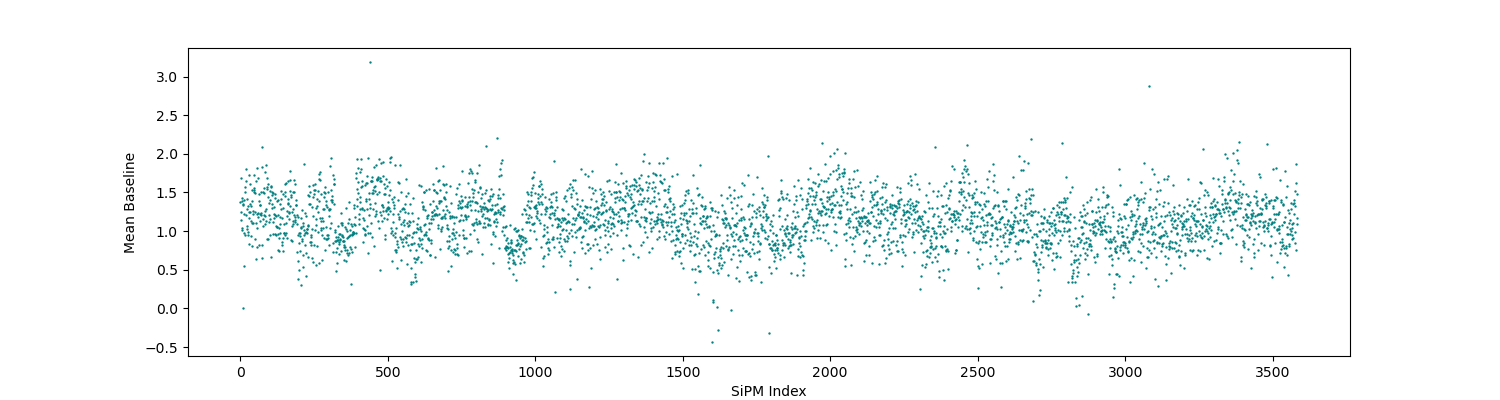

In [52]:
# plt.plot(S2_areas)
plt.figure(figsize=(15, 4))

plt.scatter(np.arange(0,3584,1),rms, color="Teal", s=0.5)
plt.ylabel("RMS noise")
plt.xlabel("SiPM Index")

plt.figure(figsize=(15, 4))

plt.scatter(np.arange(0,3584,1),means, color="Teal", s=0.5)
plt.ylabel("Mean Baseline")
plt.xlabel("SiPM Index")


,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma,RMS,MEANS,SLOPE,OFFSET,S2_AREA
0,1000,56013,1,-482.625,-294.825,17.5356,2.26852,4.639024,1.030000,-0.000270,0.078460,171.175
1,1001,56012,1,-482.625,-279.275,16.8348,1.89649,4.602753,0.923333,-0.000279,-0.141180,72.300
2,1002,56015,1,-482.625,-263.725,17.2957,2.26167,5.608297,1.588333,-0.000159,0.601965,226.200
3,1003,56014,1,-482.625,-248.175,17.7361,2.26759,5.783493,1.545000,0.000441,-0.034830,124.350
4,1004,56029,1,-482.625,-232.625,16.4249,2.19263,3.890351,0.673333,0.000318,-0.024283,89.300
...,...,...,...,...,...,...,...,...,...,...,...,...
3579,56059,14054,1,490.025,245.425,17.3728,2.47312,5.052833,0.938333,-0.001353,0.479609,115.725
3580,56060,14037,1,490.025,260.975,17.9931,1.99397,4.403176,0.855000,-0.000756,0.149545,98.875
3581,56061,14036,1,490.025,276.525,16.5315,2.28669,5.296603,1.223333,-0.001862,0.338897,82.200
3582,56062,14039,1,490.025,292.075,17.1426,2.05097,4.882038,0.955000,-0.000069,-0.467336,102.350


SensorID      38030.000000
ChannelID     48019.000000
Active            1.000000
X               181.025000
Y              -263.225000
adc_to_pes       16.633200
Sigma             2.952590
RMS               3.826552
MEANS             0.550000
SLOPE            -0.001932
OFFSET            0.641868
S2_AREA         433.250000
Name: 2398, dtype: float64

Text(0, 0.5, 'Y [mm]')

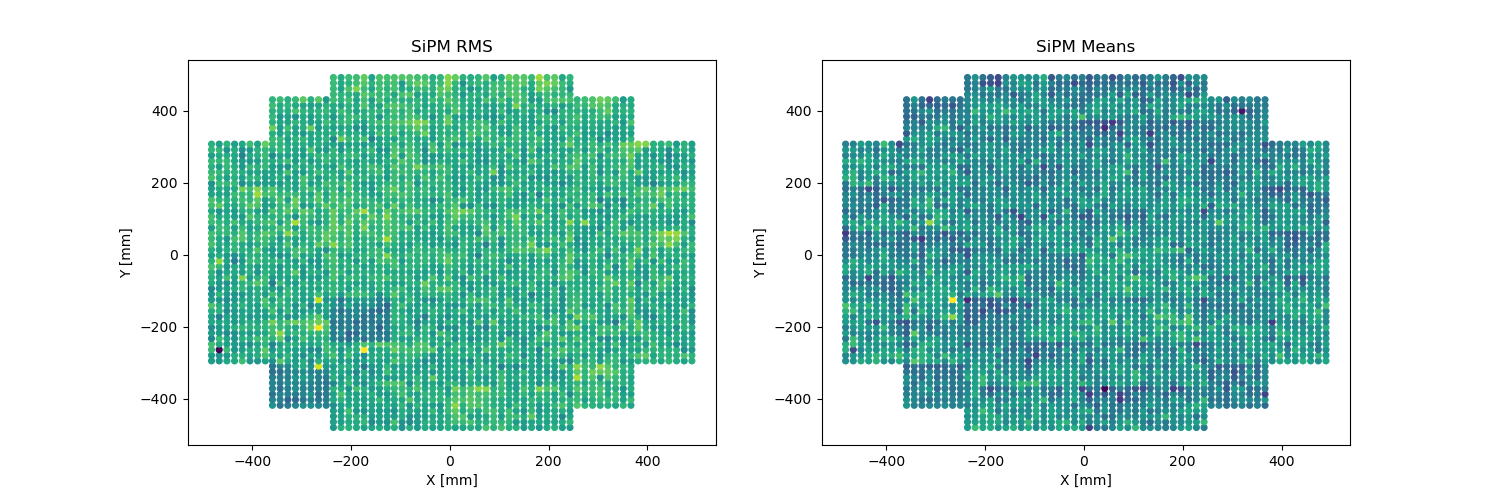

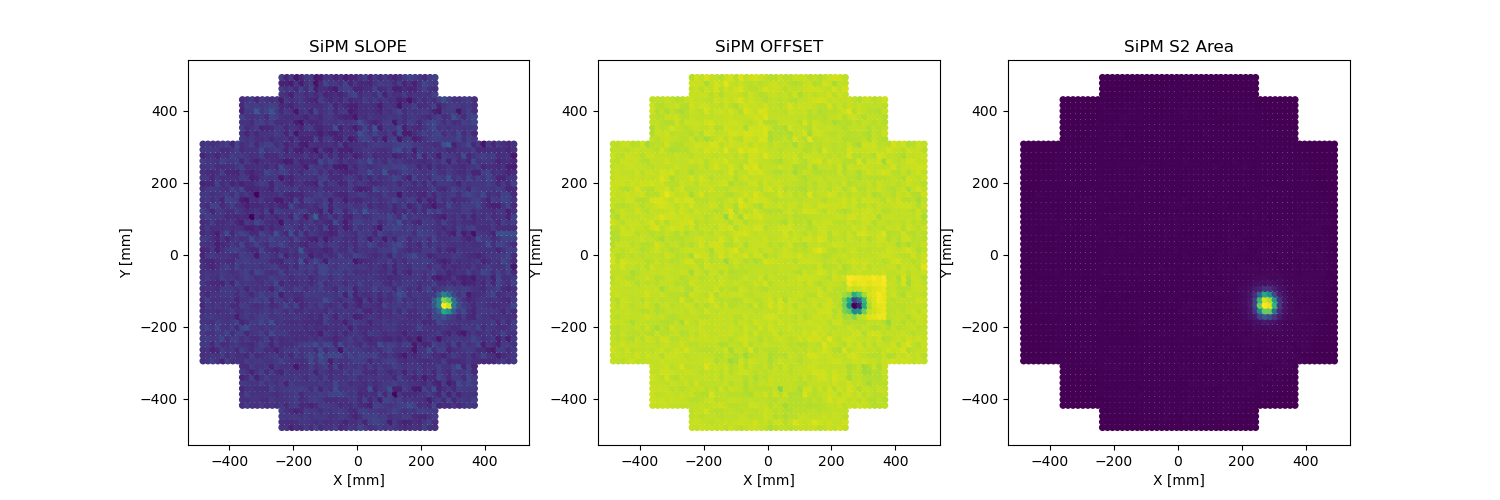

In [111]:
datasipm_copy = datasipm.copy()

datasipm_copy["RMS"] = pd.Series(rms, index=datasipm_copy.index)
datasipm_copy["MEANS"] = pd.Series(means, index=datasipm_copy.index)
datasipm_copy["SLOPE"] = pd.Series(slopes, index=datasipm_copy.index)
datasipm_copy["OFFSET"] = pd.Series(offsets, index=datasipm_copy.index)
datasipm_copy["S2_AREA"] = pd.Series(S2_areas, index=datasipm_copy.index)



display(datasipm_copy)

display(datasipm_copy.iloc[2398])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# axs[0].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.RMS, s = 17, norm=mcolors.LogNorm())
axs[0].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.RMS, s = 17)
axs[0].set_title("SiPM RMS")
axs[0].set_xlabel("X [mm]")
axs[0].set_ylabel("Y [mm]")

# axs[1].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.MEANS, s = 17, norm=mcolors.LogNorm())
axs[1].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.MEANS, s = 17)
axs[1].set_title("SiPM Means")
axs[1].set_xlabel("X [mm]")
axs[1].set_ylabel("Y [mm]")



fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.SLOPE*1000, s = 17)
axs[0].set_title("SiPM SLOPE")
axs[0].set_xlabel("X [mm]")
axs[0].set_ylabel("Y [mm]")

axs[1].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.OFFSET, s = 17)
axs[1].set_title("SiPM OFFSET")
axs[1].set_xlabel("X [mm]")
axs[1].set_ylabel("Y [mm]")

axs[2].scatter(datasipm_copy.X, datasipm_copy.Y, c=datasipm_copy.S2_AREA, s = 17)
axs[2].set_title("SiPM S2 Area")
axs[2].set_xlabel("X [mm]")
axs[2].set_ylabel("Y [mm]")




Lower Band: 2945 29338.200000000004 3.092080541280338
Top Band: 2953 49223.69999999998 9.74079306683941
Huge Band: 2954 64282.22499999999 18.169976620392905
Huge Band: 2955 60648.674999999996 14.426930222035724
Huge Band: 2962 62213.04999999999 16.831578503462502
Huge Band: 2963 56023.75 12.519773867714322
[2598, 2599, 2607, 2598, 2598, 2599, 2607, 2672, 2598, 2599, 2607, 2672, 1391, 1399, 1391, 1399, 1440, 1441, 1448, 1449, 1456, 1457, 1391, 1399, 1440, 1441, 1448, 1449, 1456, 1457, 1391, 1399, 1440, 1441, 1448, 1449, 1456, 1457, 21, 32, 60, 118, 119, 129, 142, 159, 162, 167, 182, 245, 246, 264, 283, 285, 389, 391, 426, 438, 459, 486, 488, 511, 518, 527, 534, 535, 550, 594, 636, 673, 698, 700, 709, 738, 758, 770, 775, 776, 869, 871, 894, 914, 917, 1022, 1057, 1058, 1068, 1070, 1076, 1085, 1121, 1143, 1153, 1155, 1188, 1206, 1208, 1211, 1225, 1235, 1245, 1256, 1273, 1310, 1348, 1349, 1385, 1391, 1399, 1414, 1420, 1429, 1430, 1431, 1438, 1440, 1441, 1447, 1448, 1449, 1456, 1457, 1483, 1

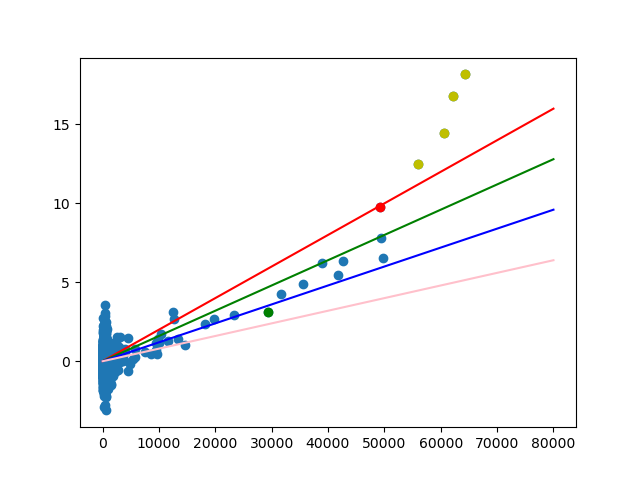

In [112]:
plt.figure()

plt.scatter(S2_areas, np.array(slopes)*1000)
# plt.scatter(S2_areas, offsets)
# plt.scatter(S2_areas, intercepts)


x_line = np.linspace(0, 80e3, len(slopes))

plt.plot(x_line, 2e-4*x_line, color='red')
plt.plot(x_line, 1.6e-4*x_line, color='green')
plt.plot(x_line, 1.2e-4*x_line, color='blue')
plt.plot(x_line, 8e-5*x_line, color='pink')


for i, (area, slope) in enumerate(zip(S2_areas, slopes)):

    y_upper = 2e-4 * area
    y_lower = 1.6e-4 * area
    if (area > 20e3 and y_lower <= slope*1000 <= y_upper):
        print("Top Band:", i, area, slope*1000)
        plt.scatter(area, slope*1000, c="r")
        indexes.append(i)

    y_upper = 1.2e-4 * area
    y_lower = 8e-5 * area
    if (area > 20e3 and y_lower <= slope*1000 <= y_upper):
        print("Lower Band:", i, area, slope*1000)
        plt.scatter(area, slope*1000, c="g")
        indexes.append(i)

    y_upper = 2e-4 * area
    if (area > 30e3 and slope*1000 > y_upper):
        print("Huge Band:", i, area, slope*1000)
        plt.scatter(area, slope*1000, c="y")
        indexes.append(i)

    y_upper = 2e-4 * area
    if (slope*1000 < -5):
        print("Low Band:", i, area, slope*1000)
        plt.scatter(area, slope*1000, c="k")
        indexes.append(i)

print(indexes)

,event,sipm_index,S2_area,X,Y,slope,intercept,offset
0,13,810,1013.850,-158.075,-448.825,0.000564,-1.600484,-0.528426
1,13,811,1266.900,-158.075,-433.275,0.000807,-1.653258,-0.120459
2,13,812,1196.250,-158.075,-417.725,0.000744,-1.508594,-0.094244
3,13,818,1818.425,-142.525,-448.825,0.000641,-1.570862,-0.352020
4,13,819,1859.400,-142.525,-433.275,0.000481,-0.991741,-0.078788
...,...,...,...,...,...,...,...,...
72,13,1368,1033.000,-65.775,-356.525,-0.000256,0.340200,-0.146627
73,13,1793,1372.500,10.975,-464.375,-0.001304,2.883859,0.406434
74,13,1794,1259.750,10.975,-448.825,-0.001665,3.313399,0.150493
75,13,1795,1140.300,10.975,-433.275,-0.000223,0.223594,-0.199690


,event,sipm_index,S2_area,X,Y,slope,intercept,offset


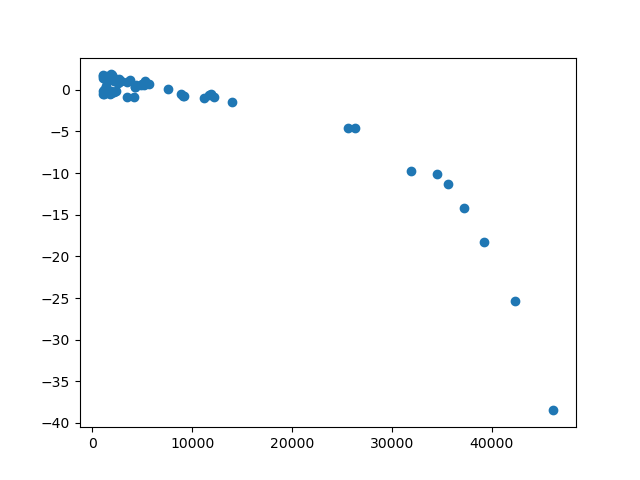

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [ ]:

sipm_properties = []

for index in datasipm.index:
    if (S2_areas[index] < 1000):
        continue
    sipm_properties.append(pd.DataFrame(dict(event = event_number, sipm_index=index,S2_area=S2_areas[index], X=datasipm.iloc[index].X, Y=datasipm.iloc[index].Y, slope=slopes[index], intercept=intercepts[index], offset=offsets[index]), index=[0]))

sipm_properties = pd.concat(sipm_properties, ignore_index=True)
display(sipm_properties)

plt.figure()
plt.scatter(sipm_properties.S2_area, sipm_properties.offset)


display(sipm_properties[sipm_properties.S2_area > 50e3])


In [82]:
# RUN=14180
RUN=14498
df = pd.read_hdf(f"../data/analysis/Run_{RUN}_SiPM.h5")


df["slope"] = df["slope"]*1000
df["slope_norm"] = df["slope"]/df["S2_area"]
df["offset_norm"] = df["offset"]/df["S2_area"]

display(df)

,event,sipm_index,S2_area,X,Y,slope,intercept,offset,slope_norm,offset_norm
0,0,1585,1166.72,-19.125,29.225,-0.037362,0.154686,0.091171,-0.000032,0.000078
1,0,1589,1173.32,-19.125,91.425,-0.183345,0.592168,0.280482,-0.000156,0.000239
2,0,1590,1002.68,-19.125,106.975,-0.112855,0.594121,0.402269,-0.000113,0.000401
3,0,1592,1750.88,-3.575,13.675,-0.648375,0.527220,-0.575018,-0.000370,-0.000328
4,0,1593,1867.76,-3.575,29.225,0.406074,-3.778024,-3.087699,0.000217,-0.001653
...,...,...,...,...,...,...,...,...,...,...
6141,58,1684,2559.96,-81.325,322.675,0.419502,-1.518827,-0.805674,0.000164,-0.000315
6142,58,1685,2086.96,-81.325,338.225,0.174894,0.512602,0.809922,0.000084,0.000388
6143,58,1686,1136.60,-81.325,353.775,0.347617,-2.258328,-1.667379,0.000306,-0.001467
6144,58,1688,1309.24,-65.775,260.475,0.124091,-0.381001,-0.170046,0.000095,-0.000130


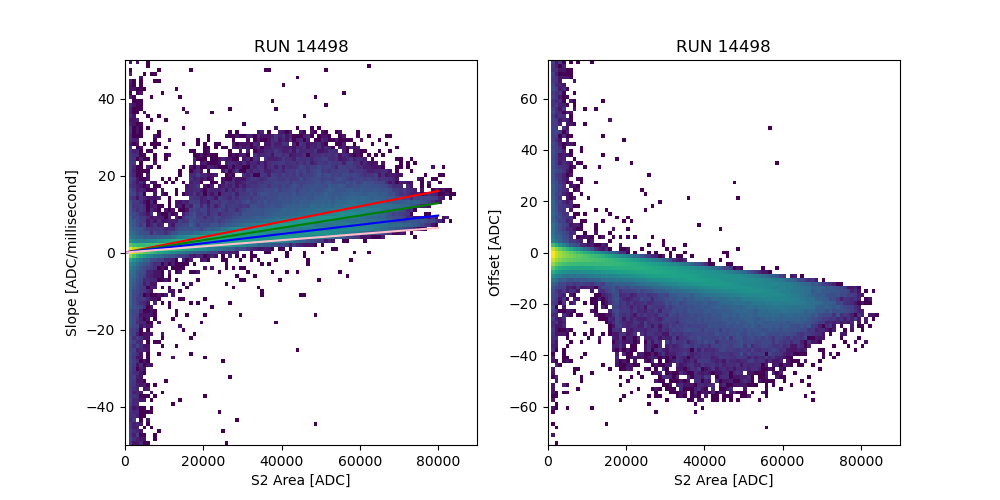

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

def Plot2D(df, var, ax, RUN, ylabel):

    if var == "slope":
         bins=[np.linspace(0,90e3,100), np.linspace(-50,50,100)]
    else:
        bins =[np.linspace(0,90e3,100), np.linspace(-75,75,100)]
    

    hist, x_edges, y_edges = np.histogram2d(df.S2_area, df[f"{var}"],bins=bins)


    # Mask zero bins
    hist_masked = np.ma.masked_where(hist == 0, hist)  # Mask zero-count bins

    # Plot using pcolormesh (avoids zero bins)
    X, Y = np.meshgrid(x_edges, y_edges)
    c = ax.pcolormesh(X, Y, hist_masked.T, cmap="viridis",norm=mcolors.LogNorm())  # Transpose hist for correct orientation

    # Labels and title
    ax.set_xlabel("S2 Area [ADC]")
    ax.set_ylabel(f"{ylabel}")
    ax.set_title(f"RUN {RUN}")


Plot2D(df, "slope", axs[0],RUN, "Slope [ADC/millisecond]")
x_line = np.linspace(0,80e3, 100)
axs[0].plot(x_line, 2e-4*x_line, color='red')
axs[0].plot(x_line, 1.6e-4*x_line, color='green')
axs[0].plot(x_line, 1.2e-4*x_line, color='blue')
axs[0].plot(x_line, 8e-5*x_line, color='pink')




Plot2D(df, "offset", axs[1],RUN, "Offset [ADC]")








Text(0.5, 0, 'SiPM index')

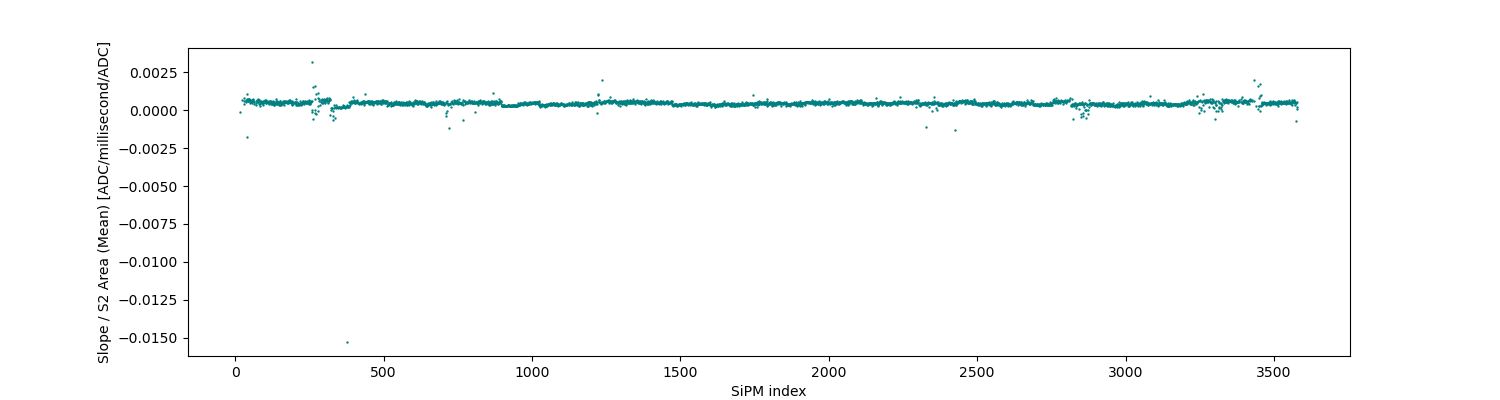

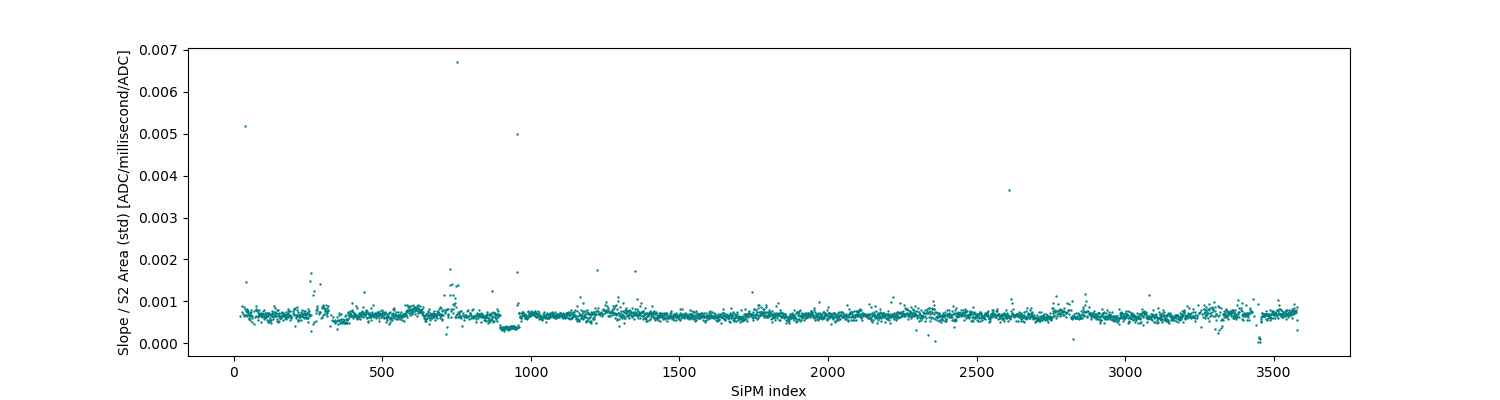

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [ ]:
sipm_slopes_mean = df.groupby(["sipm_index"])["slope_norm"].mean()
sipm_slopes_std  = df.groupby(["sipm_index"])["slope_norm"].std()
plt.figure(figsize=(15, 4))
plt.scatter( sipm_slopes_mean.index, sipm_slopes_mean, color="Teal", s=0.5)
plt.xlabel("SiPM index")
plt.ylabel("Slope / S2 Area (Mean) [ADC/millisecond/ADC]")
plt.figure(figsize=(15, 4))
plt.scatter( sipm_slopes_std.index, sipm_slopes_std, color="Teal", s=0.5)
plt.ylabel("Slope / S2 Area (std) [ADC/millisecond/ADC]")
plt.xlabel("SiPM index")


Text(0.5, 0, 'SiPM index')

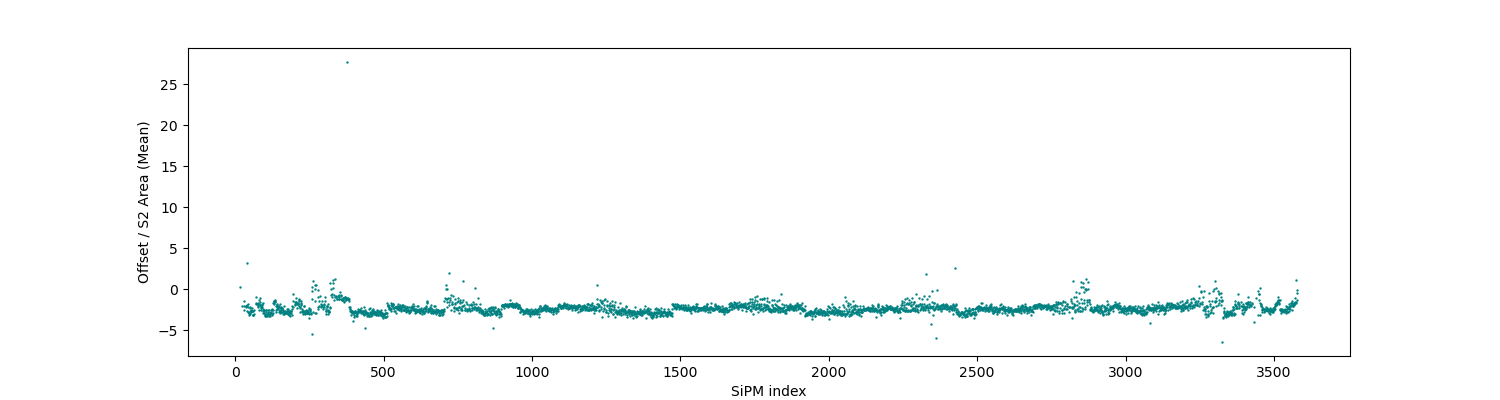

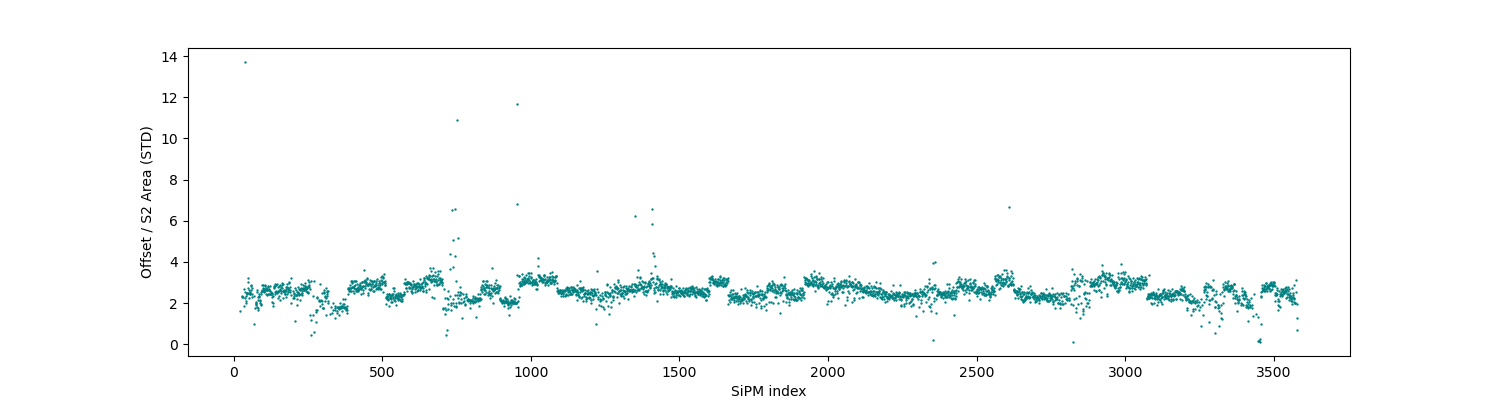

In [ ]:
sipm_offset_mean = df.groupby(["sipm_index"])["offset"].mean()
sipm_offset_std = df.groupby(["sipm_index"])["offset"].std()
plt.figure(figsize=(15, 4))
plt.scatter( sipm_offset_mean.index, sipm_offset_mean, color="Teal", s=0.5)
plt.xlabel("SiPM index")
plt.ylabel("Offset / S2 Area (Mean)")
plt.figure(figsize=(15, 4))
plt.scatter(sipm_offset_std.index,  sipm_offset_std, color="Teal", s=0.5)
plt.ylabel("Offset / S2 Area (STD)")
plt.xlabel("SiPM index")

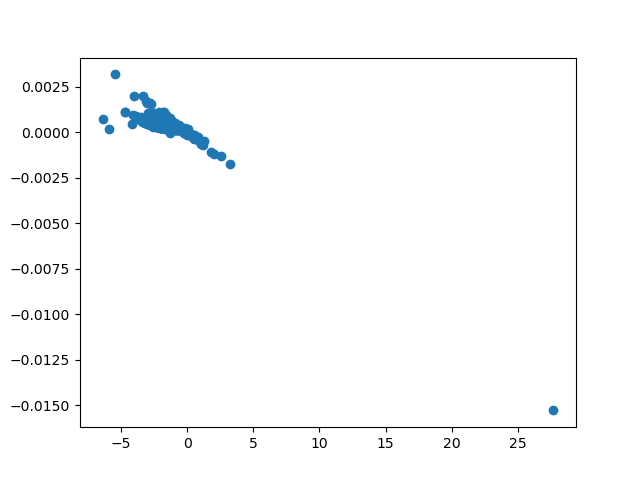

In [ ]:
plt.figure()


plt.scatter(sipm_offset_mean, sipm_slopes_mean)
